In [ ]:
import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
import anndata as ad

In [3]:
import os
os.getcwd()

'/home/varsha/venvv'

In [4]:
GSE279086_raw_adata = ad.read_h5ad("/mnt/c/Users/VARSHA/Documents/rna_seq/GSE279086/bonus/output/03_GSE279086_seurat_pca_umap.h5ad")
GSE279086_raw_adata


AnnData object with n_obs × n_vars = 6327 × 16832
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'percent.rb', 'Condition', 'Sample', 'mahal_dist_nCount', 'pca_clusters', 'ident'
    uns: 'X_name'
    obsm: 'PCA', 'UMAP'
    layers: 'logcounts'

In [5]:
GSE279086_harmony_adata = ad.read_h5ad("/mnt/c/Users/VARSHA/Documents/rna_seq/GSE279086/bonus/output/04_GSE279086_harmony_corrected.h5ad")
GSE279086_harmony_adata

AnnData object with n_obs × n_vars = 6327 × 16832
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'percent.rb', 'Condition', 'Sample', 'mahal_dist_nCount', 'pca_clusters', 'harmony_nn_res.0.8', 'seurat_clusters', 'ident'
    uns: 'X_name'
    obsm: 'HARMONY', 'PCA', 'UMAP'
    layers: 'logcounts'

(6327, 2)


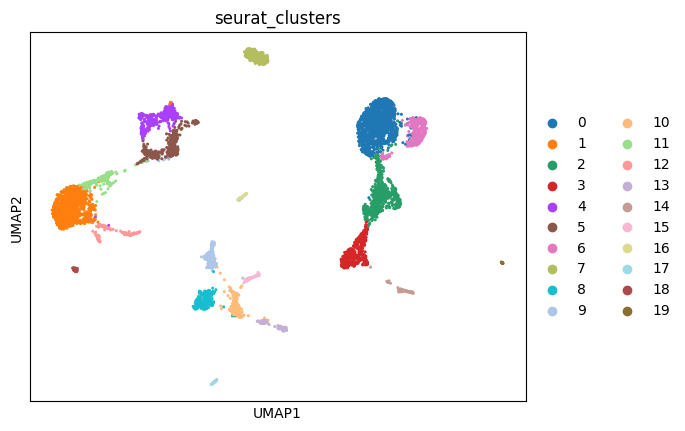

In [6]:
import numpy as np
import scanpy as sc

# Load Seurat UMAP coordinates
umap_df = pd.read_csv(
    "/mnt/c/Users/VARSHA/Documents/rna_seq/GSE279086/GSE279086_umap_coordinates.csv",
    index_col=0
)

# Sanity check
print(umap_df.shape)   # should be (5405, 2)

# Inject into AnnData
GSE279086_harmony_adata.obsm['X_umap'] = umap_df.loc[
    GSE279086_harmony_adata.obs_names
].values

sc.pl.umap(
    GSE279086_harmony_adata,
    color='seurat_clusters',
    show=True
)

In [7]:
# Put log-normalized counts into X (only for CellTypist)
GSE279086_harmony_adata.X = GSE279086_harmony_adata.layers['logcounts'].copy()

In [8]:
import celltypist
ct_pred = celltypist.annotate(
    GSE279086_harmony_adata,
    model="/mnt/c/Users/VARSHA/Documents/rna_seq/GSE279086/Adult_Human_Kidney.pkl",
    majority_voting=True
)

/home/varsha/venvv/lib/python3.12/site-packages/celltypist/classifier.py:11: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  from scanpy import __version__ as scv
🔬 Input data has 6327 cells and 16832 genes
🔗 Matching reference genes in the model
🧬 9156 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [9]:
GSE279086_harmony_adata.obs['majority_voting'] = (
    ct_pred.predicted_labels['majority_voting']
    .astype(str)
)

In [10]:
print(GSE279086_harmony_adata.obs['majority_voting'].value_counts().head())

majority_voting
EC-PTC    1248
PC        1212
VSMC/P     545
DTL        445
EC-DVR     414
Name: count, dtype: int64


In [11]:
import matplotlib.pyplot as plt
import os

outdir = "/mnt/c/Users/VARSHA/Documents/rna_seq/GSE279086/bonus/plots/celltypist_plot"
os.makedirs(outdir, exist_ok=True)

... storing 'majority_voting' as categorical


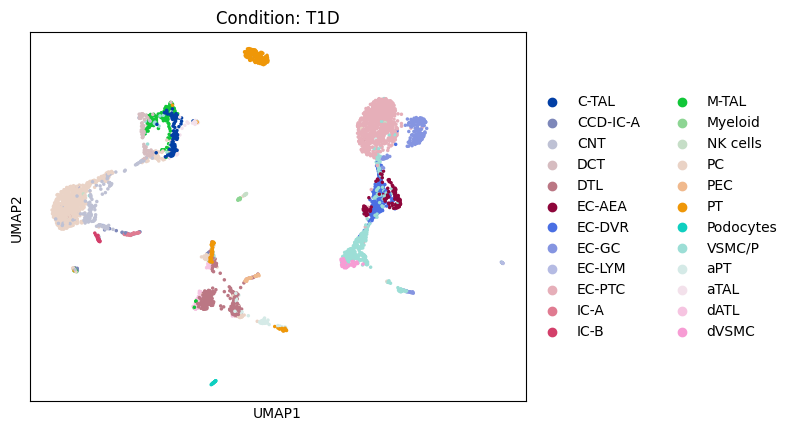

... storing 'majority_voting' as categorical


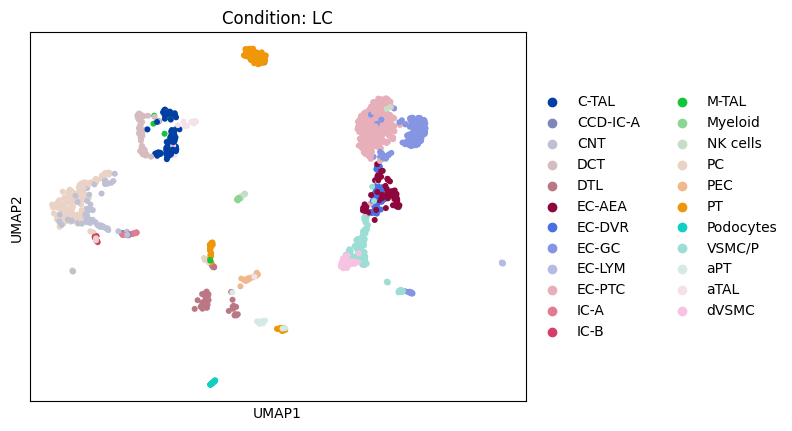

In [12]:
for cond in GSE279086_harmony_adata.obs['Condition'].unique():
    fig = sc.pl.umap(
        GSE279086_harmony_adata[
            GSE279086_harmony_adata.obs['Condition'] == cond
        ],
        color='majority_voting',
        title=f'Condition: {cond}',
        legend_loc='right margin',
        show=False,
        return_fig=True
    )
    plt.savefig(
        f"/mnt/c/Users/VARSHA/Documents/rna_seq/GSE279086/bonus/plots/celltypist_plot/umap_celltypes_ct_{cond}.png",
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()

In [13]:
# Move log-normalized expression into X for CellTypist
GSE279086_raw_adata.X = GSE279086_raw_adata.layers['logcounts'].copy()

GSE279086_predictions3 = celltypist.annotate(
    GSE279086_raw_adata, 
    model='/mnt/c/Users/Varsha/Documents/rna_seq/GSE279086/Adult_Human_Kidney.pkl',
    majority_voting=True
)

# Save majority voting to obs
GSE279086_raw_adata.obs["majority_voting"] = GSE279086_predictions3.predicted_labels["majority_voting"].astype(str)

🔬 Input data has 6327 cells and 16832 genes
🔗 Matching reference genes in the model
🧬 9156 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


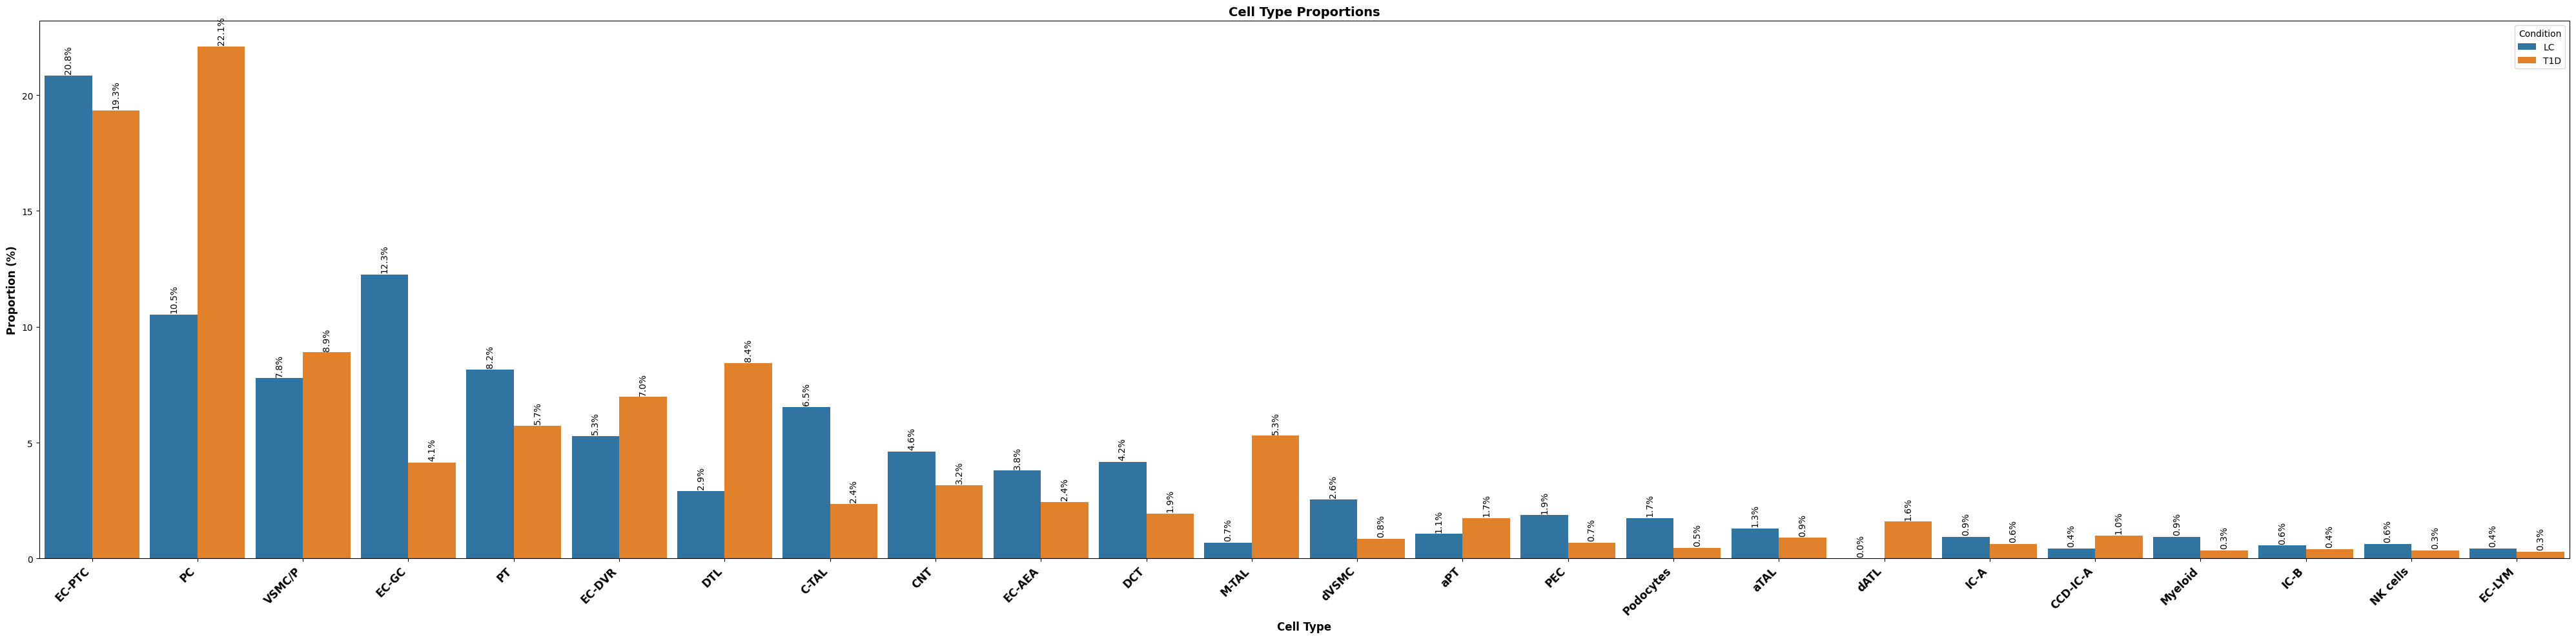

In [14]:
import seaborn as sns
# Step 1: Count cells per cell type per condition
n_cells_condition = (
    GSE279086_raw_adata.obs
    .groupby(["Condition", "majority_voting"])
    .size()
    .reset_index(name="count")
)

# Step 2: Calculate proportions per condition
n_cells_condition["total"] = n_cells_condition.groupby("Condition")["count"].transform("sum")
n_cells_condition["proportion"] = (n_cells_condition["count"] / n_cells_condition["total"]) * 100

# Step 3: Compute average proportion per cell type for ordering
avg_proportions = (
    n_cells_condition
    .groupby("majority_voting")["proportion"]
    .mean()
    .sort_values(ascending=False)
)
ordered_celltypes = avg_proportions.index.tolist()

# Step 4: Plot
plt.figure(figsize=(40, 10))
ax = sns.barplot(
    data=n_cells_condition,
    x="majority_voting",
    y="proportion",
    hue="Condition",
    order=ordered_celltypes,
    dodge=True,
    width=0.9
)

# Step 5: Add proportion labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=2, fontsize=10, rotation = 90)

# Customize axes
plt.xticks(rotation=45, ha="right", fontsize=12, fontweight="bold")
plt.ylabel("Proportion (%)", fontsize=12, fontweight="bold")
plt.xlabel("Cell Type", fontsize=12, fontweight="bold")
plt.title("Cell Type Proportions", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("/mnt/c/Users/Varsha/Documents/rna_seq/GSE279086/bonus/plots/celltypist_plot/Cellproportions_barplot.png", dpi=300, bbox_inches='tight')
plt.show()

n_cells_condition.to_csv("Cellproportions.csv", index=False)

In [15]:
# Create combined group label FIRST
GSE279086_raw_adata.obs['majority_voting'] = (
    GSE279086_raw_adata.obs['majority_voting'].astype(str)
    + "_" +
    GSE279086_raw_adata.obs['Condition'].astype(str)
)

In [16]:
def find_unique_markers(
    adata, 
    groupby='cell_type', 
    method='wilcoxon', 
    pval_threshold=0.05, 
    logfc_threshold=0.25,
    top_n=3,
    min_cells_per_group=2
):
    """
    Mimics Seurat's FindAllMarkers + filters for unique DEGs per cluster.
    
    Parameters:
        adata : AnnData object
        groupby : column in adata.obs to group cells (e.g., clusters, cell_type)
        method : DEG test method ('wilcoxon', 't-test', 'logreg')
        pval_threshold : adjusted p-value threshold for significance
        logfc_threshold : log fold change threshold for filtering

    Returns:
        unique_degs_df : DataFrame of DEGs unique to each group
    """

    # Filter out low-cell groups
    group_counts = adata.obs[groupby].value_counts()
    valid_groups = group_counts[group_counts >= min_cells_per_group].index.tolist()

    # Subset AnnData to valid groups only
    adata_filtered = adata[adata.obs[groupby].isin(valid_groups)].copy()
    
    # Run DEG analysis
    sc.tl.rank_genes_groups(adata_filtered, groupby=groupby, method=method)
    
    # Get full results into a DataFrame
    all_degs = sc.get.rank_genes_groups_df(adata_filtered, group=None)
    
    # Filter by significance
    filtered_degs = all_degs[
        (all_degs['pvals_adj'] < pval_threshold) &
        (abs(all_degs['logfoldchanges']) > logfc_threshold)
    ]

    # Find genes that appear in only one group
    unique_genes = (
        filtered_degs.groupby('names')['group']
        .nunique()
        .reset_index()
        .query('group == 1')['names']
        .tolist()
    )

    # Keep only unique DEGs
    unique_degs_df = filtered_degs[filtered_degs['names'].isin(unique_genes)].copy()


    # Select top N per group by logFC
    top_unique_degs_df = (
        unique_degs_df
        .sort_values(['group', 'logfoldchanges'], ascending=[True, False])
        .groupby('group')
        .head(top_n)
        .reset_index(drop=True)
    )

    return top_unique_degs_df

In [17]:
unique_markers = find_unique_markers(
    GSE279086_raw_adata, 
    groupby='majority_voting',
    method='wilcoxon',
    pval_threshold=0.05, 
    logfc_threshold=0.25,
    top_n=3, 
    min_cells_per_group=2
)

unique_markers['group'] = (
    unique_markers['group']
    .str.replace(r'_(HCKD|Healthy|AKI|DKD)_\1$', r'_\1', regex=True)
)

# Inspect & save
print(unique_markers.head())
unique_markers['group'].drop_duplicates()

unique_markers.to_csv("Unique_cluster_markers.csv", index=False)

... storing 'majority_voting' as categorical
/home/varsha/venvv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:457: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/varsha/venvv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:459: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/varsha/venvv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:462: Performanc

       group    names    scores  logfoldchanges         pvals     pvals_adj
0   C-TAL_LC   SH3D21  3.618440        3.483229  2.963844e-04  7.209165e-03
1   C-TAL_LC  SULT1A1  3.141554        2.420763  1.680539e-03  3.111863e-02
2  C-TAL_T1D    TYRP1  5.395133        5.477976  6.847263e-08  3.481968e-06
3  C-TAL_T1D      F11  6.356507        4.867572  2.063924e-10  1.638678e-08
4  C-TAL_T1D    LYPD6  3.127716        3.929460  1.761704e-03  2.898632e-02


... storing 'majority_voting' as categorical


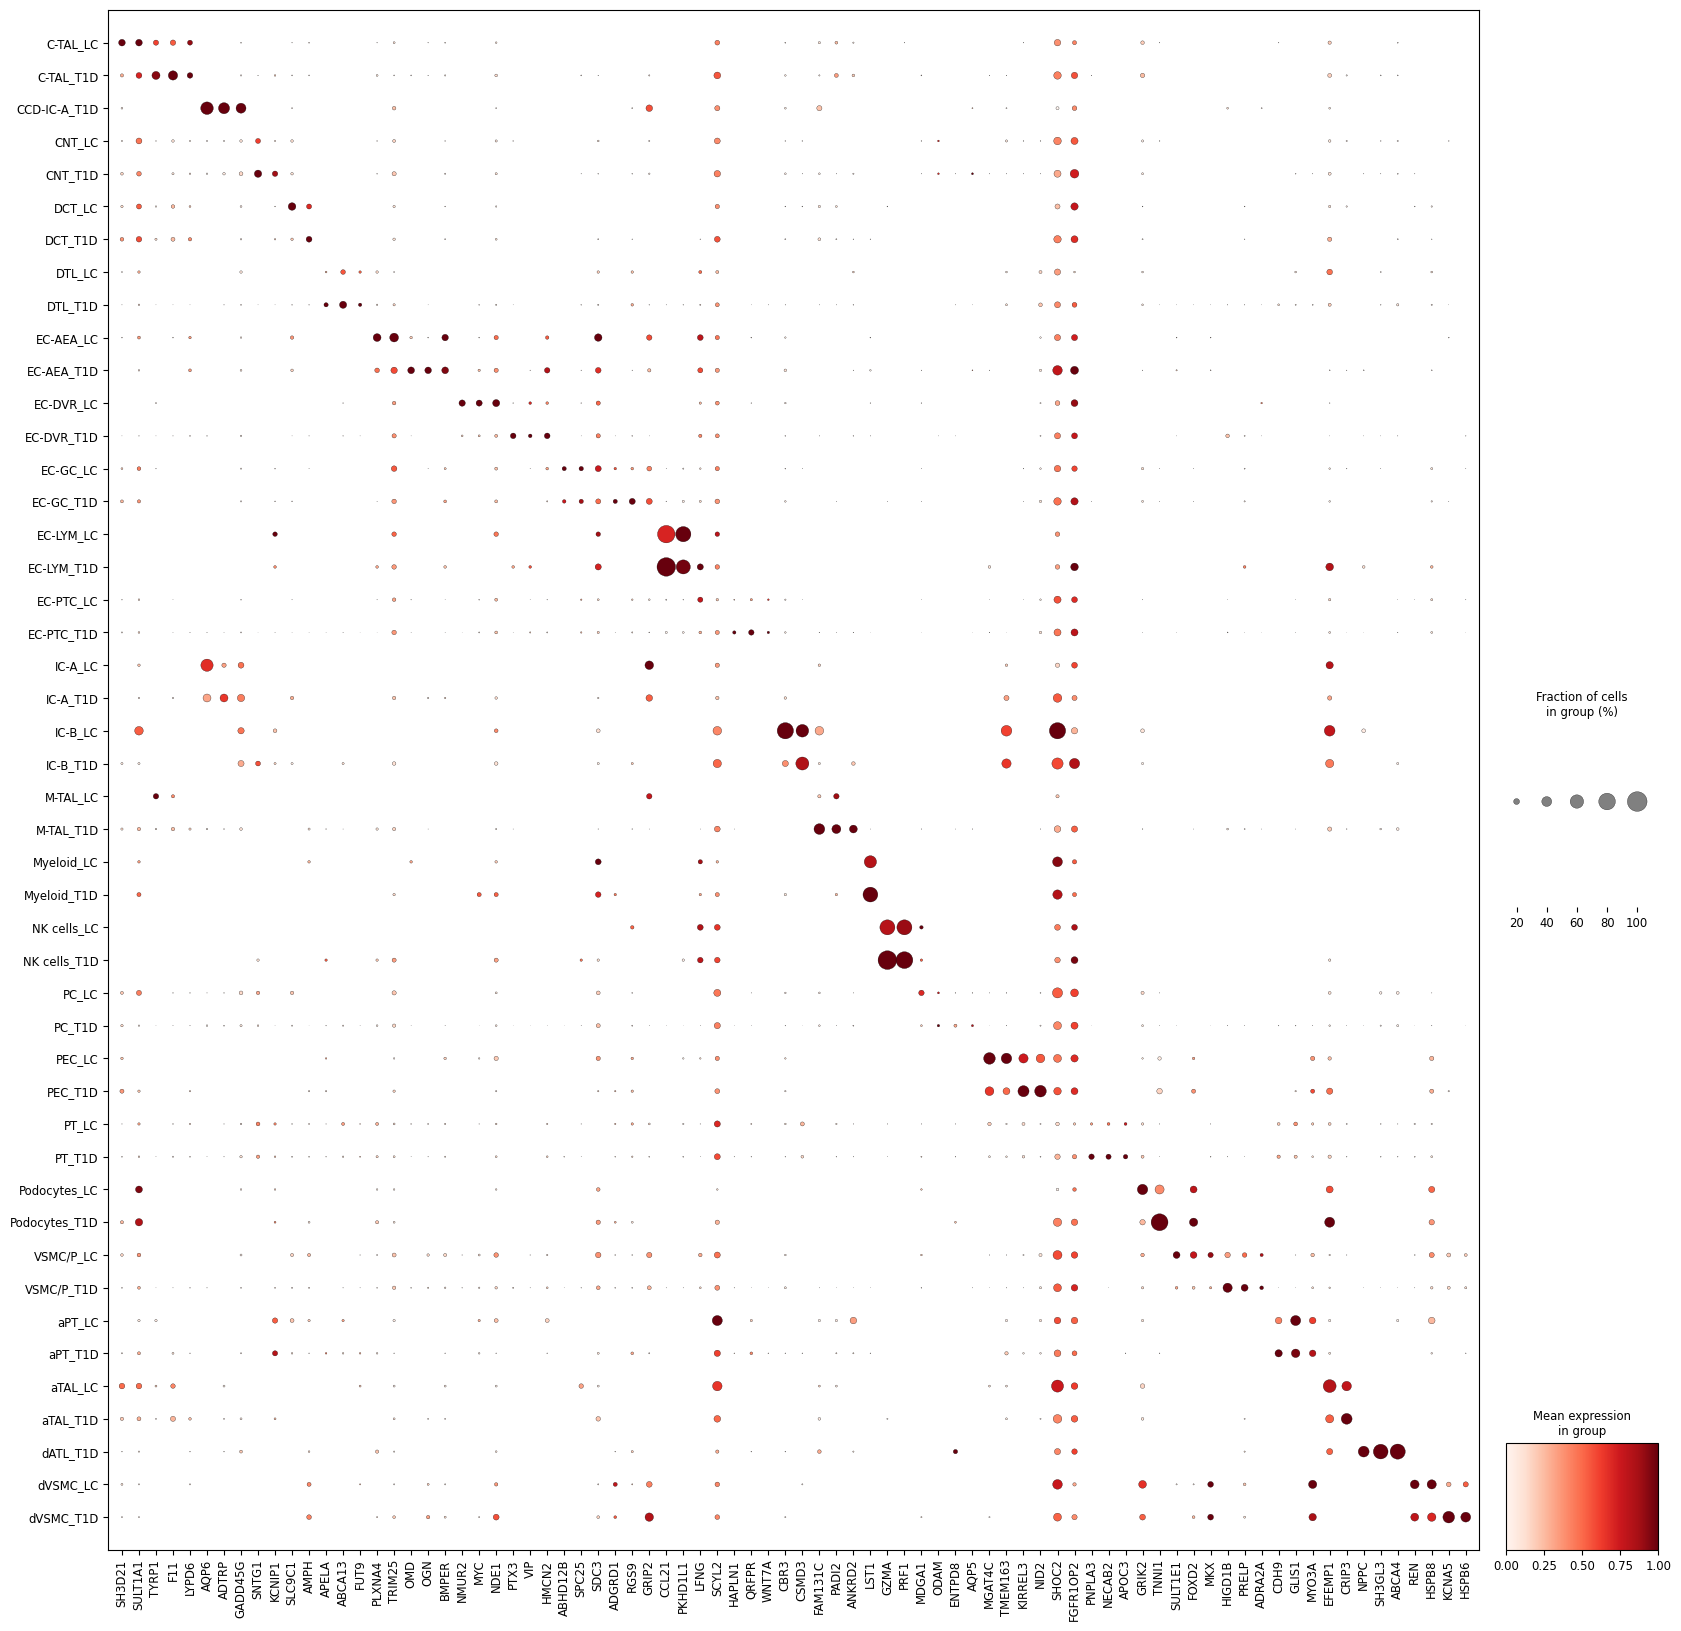

In [18]:
excluded_prefixes = ["Classical monocytes"]
mask = ~GSE279086_raw_adata.obs['majority_voting'].str.startswith(tuple(excluded_prefixes))
adata_to_plot = GSE279086_raw_adata[mask].copy()

genes_to_plot = unique_markers["names"].tolist()  # top 3 per group
# Keep only genes that exist in adata.var_names
genes_to_plot = [g for g in genes_to_plot if g in adata_to_plot.var_names]

X = adata_to_plot[:, genes_to_plot].X
if hasattr(X, "toarray"):  # sparse -> dense
    X = X.toarray()

# Make a DataFrame: rows = cell types, columns = genes
expr_df = pd.DataFrame(X, index=adata_to_plot.obs['majority_voting'], columns=genes_to_plot)

expr_per_group = expr_df.groupby(expr_df.index).sum()  # rows = groups, columns = genes

# Keep only genes where max across groups ≥ 30
genes_filtered = expr_per_group.columns[(expr_per_group.max(axis=0) >= 30)].tolist()

# Filter expression DataFrame
expr_per_group = expr_per_group[genes_filtered]

valid_groups = expr_per_group.index[(expr_per_group.sum(axis=1) > 20)].tolist()
adata_to_plot = adata_to_plot[adata_to_plot.obs['majority_voting'].isin(valid_groups)].copy()

sc.pl.dotplot(
    adata_to_plot,
    var_names=genes_filtered,
    groupby='majority_voting',
    standard_scale='var',
    show=False,
    figsize=(20, 20),
    dendrogram=False
)
plt.savefig("/mnt/c/Users/Varsha/Documents/rna_seq/GSE279086/bonus/plots/celltypist_plot/Cluster_Markergenes.png", dpi=300, bbox_inches='tight')
plt.show()

In [19]:
GSE279086_raw_adata.write("/mnt/c/Users/Varsha/Documents/rna_seq/GSE279086/bonus/output/GSE279086_celltypist.h5ad")

... storing 'majority_voting' as categorical
